# MTA 2022 Subway Data Exploration
---
This notebook will explore 2022 Subway ridership data. It will follow largely the same steps as the 2022 taxi dataset previously analysed. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import calendar
from shapely.geometry import Point, Polygon
import os

## February-December 2022
---
Due to a formatting change introduced in February 2022, the data from February 2022 onwards is different. The new format is much easier to read and alayse, so we will start with this before looking at the January 2022 data.

In [2]:
df = pd.read_csv('Subway_Data/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4956086 entries, 0 to 4956085
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   transit_timestamp   object 
 1   station_complex_id  object 
 2   station_complex     object 
 3   borough             object 
 4   routes              object 
 5   payment_method      object 
 6   ridership           int64  
 7   transfers           int64  
 8   latitude            float64
 9   longitude           float64
 10  Georeference        object 
dtypes: float64(2), int64(2), object(7)
memory usage: 415.9+ MB


In [4]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference
0,06/27/2022 03:00:00 AM,R412,Hunts Point Av (6),BX,6,all,24,0,40.82095,-73.89055,POINT (-73.89055 40.82095)
1,07/25/2022 03:00:00 AM,R412,Hunts Point Av (6),BX,6,all,16,0,40.82095,-73.89055,POINT (-73.89055 40.82095)
2,02/06/2022 09:00:00 PM,R624,Kingston Av (3),BK,3,all,26,0,40.66940,-73.94216,POINT (-73.94216 40.6694)
3,02/07/2022 12:00:00 AM,R624,Kingston Av (3),BK,3,all,2,0,40.66940,-73.94216,POINT (-73.94216 40.6694)
4,02/05/2023 10:00:00 PM,R252,103 St (6),M,6,all,56,0,40.79060,-73.94748,POINT (-73.94748 40.7906)


We are only interested in the 2022 data for Manhattan for now, and as such will filter to only include this. We also extract some date time features from the transit timestamp, and use this for removing 2023 data. 

In [5]:
# Keeping only Manhattan
df = df[df['borough'] == 'M']

In [6]:
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

# Extracting datetime features
df['date'] = df['transit_timestamp'].dt.strftime('%Y-%m-%d')
df['hour'] = df['transit_timestamp'].dt.hour
df['day'] = df['transit_timestamp'].dt.day_name()
df['month'] = df['transit_timestamp'].dt.month

In [7]:
# Keeping only 2022 ridership details
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year == 2022]

In [8]:
# Sorting by date
df = df.sort_values(by='date', ascending=True)
df = df.reset_index(drop=True)

In [9]:
df

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,date,hour,day,month
0,2022-02-01 10:00:00,R106,WTC Cortlandt (1),M,1,all,87,0,40.711834,-74.01219,POINT (-74.01219 40.711834),2022-02-01,10,Tuesday,2
1,2022-02-01 21:00:00,R185,191 St (1),M,1,all,52,0,40.855225,-73.92941,POINT (-73.92941 40.855225),2022-02-01,21,Tuesday,2
2,2022-02-01 02:00:00,A022,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",M,"F,M,N,R,Q,B,W,D",all,76,0,40.749718,-73.98782,POINT (-73.98782 40.749718),2022-02-01,2,Tuesday,2
3,2022-02-01 06:00:00,N094,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",M,"3,C,E,2,R,,A,W",all,378,23,40.714110,-74.00858,POINT (-74.00858 40.71411),2022-02-01,6,Tuesday,2
4,2022-02-01 15:00:00,R308,145 St (3),M,3,all,109,2,40.820420,-73.93625,POINT (-73.93625 40.82042),2022-02-01,15,Tuesday,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951415,2022-12-31 12:00:00,N700,72 St (Q),M,Q,all,602,9,40.768800,-73.95843,POINT (-73.95843 40.7688),2022-12-31,12,Saturday,12
951416,2022-12-31 20:00:00,R186,Dyckman St (1),M,1,all,124,1,40.860530,-73.92554,POINT (-73.92554 40.86053),2022-12-31,20,Saturday,12
951417,2022-12-31 01:00:00,A010,"57 St-7 Av (N,Q,R,W)",M,"N,R,Q,W",all,202,3,40.764664,-73.98066,POINT (-73.98066 40.764664),2022-12-31,1,Saturday,12
951418,2022-12-31 16:00:00,A022,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",M,"F,M,N,R,Q,B,W,D",all,4755,33,40.749718,-73.98782,POINT (-73.98782 40.749718),2022-12-31,16,Saturday,12


Everything looks to have worked correctly. 
<br><br>
In terms of cleaning, the main things that could impact our analysis are negative values or missing rows, so we will check these. We will also check ridership for outliers to be safe.

**Checking for missing values**

In [10]:
df.isnull().sum()

transit_timestamp     0
station_complex_id    0
station_complex       0
borough               0
routes                0
payment_method        0
ridership             0
transfers             0
latitude              0
longitude             0
Georeference          0
date                  0
hour                  0
day                   0
month                 0
dtype: int64

No missing values, all good here.

**Checking for negative values**

In [11]:
negative_counts = {}

for column in df.columns:
    # Checking for numeric columns
    if pd.api.types.is_numeric_dtype(df[column]):
        negative_count = df[column].lt(0).sum()
        negative_counts[column] = negative_count

for column, count in negative_counts.items():
    print(f"Column '{column}' has {count} negative value(s).")

Column 'ridership' has 0 negative value(s).
Column 'transfers' has 0 negative value(s).
Column 'latitude' has 0 negative value(s).
Column 'longitude' has 951420 negative value(s).
Column 'hour' has 0 negative value(s).
Column 'month' has 0 negative value(s).


No negative values either, bar longitude but this makes sense that it's negative. Again, no issues here.

**Checking for outliers**

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ridership,951420.0,537.168640,971.442343,1.000000,64.000000,249.00000,600.000000,22243.00000
transfers,951420.0,10.590621,26.706737,0.000000,0.000000,2.00000,10.000000,818.00000
latitude,951420.0,40.770371,0.045611,40.703087,40.730953,40.76266,40.802097,40.87456
longitude,951420.0,-73.973619,0.026358,-74.014070,-73.994660,-73.98066,-73.951790,-73.90983
hour,951420.0,11.543857,6.904289,0.000000,6.000000,12.00000,18.000000,23.00000
month,951420.0,7.034730,3.143765,2.000000,4.000000,7.00000,10.000000,12.00000


The main column we're looking at in terms of outliers is ridership. While the mean is comparitvely low at approximately 537, compared to the max of 22,243 riders, this still doesn't seem unrealistic. To be extra safe we'll check the top 10 rows based on ridership in order to see if it's plausible.

In [14]:
df.nlargest(10, 'ridership')

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,date,hour,day,month
802999,2022-11-09 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,22243,91,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-11-09,17,Wednesday,11
877943,2022-12-06 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,22139,110,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-12-06,17,Tuesday,12
900704,2022-12-14 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21724,104,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-12-14,17,Wednesday,12
662228,2022-09-21 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21434,87,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-09-21,17,Wednesday,9
881294,2022-12-07 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21334,89,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-12-07,17,Wednesday,12
723604,2022-10-12 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21300,102,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-10-12,17,Wednesday,10
778144,2022-11-01 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21187,98,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-11-01,17,Tuesday,11
822354,2022-11-16 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21163,109,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-11-16,17,Wednesday,11
741561,2022-10-19 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21137,114,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-10-19,17,Wednesday,10
782811,2022-11-02 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",all,21089,108,40.75731,-73.981964,POINT (-73.981964 40.75731),2022-11-02,17,Wednesday,11


All of the top 10 rows are Times Square. Given it's popularity and the number of different lines it serves, 20,000 riders in an hour seems believable. No issues with outliers.

## Visualising the Data
---
Ridership is the target feature we are looking at to act as a proxy for busyness. The main features related to this are the date time features. Some features like payment method are not relevant for our problem. As such, we will plot the number of riders by hour, day, and month.

### Number of Riders per Hour

In [15]:
plt.rcParams['figure.figsize'] = (10, 6)

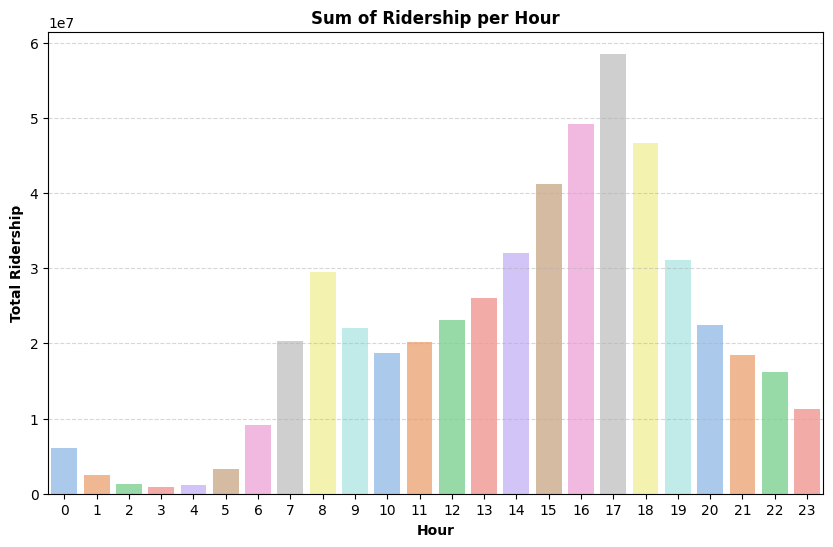

In [16]:
hourly_ridership = df.groupby('hour')['ridership'].sum()

sns.barplot(x=hourly_ridership.index, y=hourly_ridership.values, palette='pastel')
plt.xlabel('Hour', fontweight='bold')
plt.ylabel('Total Ridership', fontweight='bold')
plt.title('Sum of Ridership per Hour', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [17]:
hourly_ridership

hour
0      6058185
1      2512813
2      1339351
3       857599
4      1095180
5      3245179
6      9195366
7     20304948
8     29461066
9     22038981
10    18718361
11    20125253
12    23112880
13    26040024
14    31957745
15    41260276
16    49191595
17    58529575
18    46594083
19    31057302
20    22466447
21    18406920
22    16210154
23    11293704
Name: ridership, dtype: int64

**Observations:** The number of riders varies quite largely depending on the hour. Early morning very few are taking the subway, while evening time appears to be the busiest at 5pm. We see a peak as well at 8am, presumably as people are commuting to work in the mornings. Hour of day appears to be a good predictor for subway ridership.

### Number of Riders per Weekday

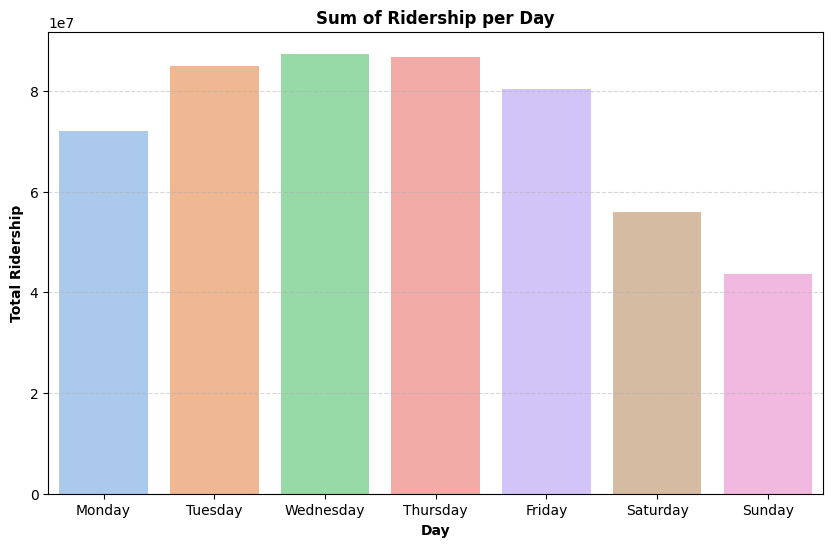

In [18]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_ridership = df.groupby('day')['ridership'].sum()

sns.barplot(x=daily_ridership.index, y=daily_ridership.values, order=day_order, palette='pastel')

plt.xlabel('Day', fontweight='bold')
plt.ylabel('Total Ridership', fontweight='bold')
plt.title('Sum of Ridership per Day', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [19]:
daily_ridership

day
Friday       80341721
Monday       71973269
Saturday     55978355
Sunday       43647957
Thursday     86747340
Tuesday      85004304
Wednesday    87380041
Name: ridership, dtype: int64

**Observations:** Weekdays Monday through Friday appear to be when most people take the subway, and weekends appear comparitvely quiter. Again, with commuting and typical work schedules this makes sense. Day of the Week also appears t be a good predictor of ridership.

### Number of Riders per Month

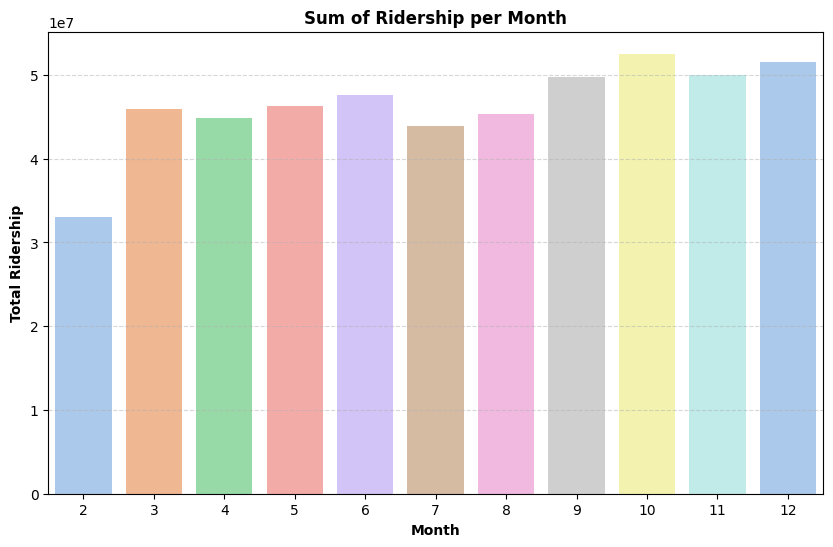

In [20]:
monthly_ridership = df.groupby('month')['ridership'].sum()

sns.barplot(x=monthly_ridership.index, y=monthly_ridership.values, palette='pastel')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Total Ridership', fontweight='bold')
plt.title('Sum of Ridership per Month', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [21]:
monthly_ridership

month
2     33096703
3     45964732
4     44833934
5     46333876
6     47618399
7     43958915
8     45383163
9     49776474
10    52539262
11    50002543
12    51564986
Name: ridership, dtype: int64

**Observations:** There is a less significant but still noticeable difference in ridership across the months. February seems quite low compared to the rest. It's hard tell why exactly, perhaps a mix of being the shortest month and some lingering effects from Covid-19. Winter months are highest in terms of ridership, maybe as the weather is worse and more people opt to take public transport. Month appears to be a good predictor of ridership.

### Number of Riders per Station
While there are too many stations to plot a readable graph, we are going to plot a bar chart without labels just to make sure there is a signficant difference across stations as this is important to our prediction. Given above we saw Times Square so high above the mean ridership, it would appear already there are particular stations that are hotspots. This is more to confirm that than anything.

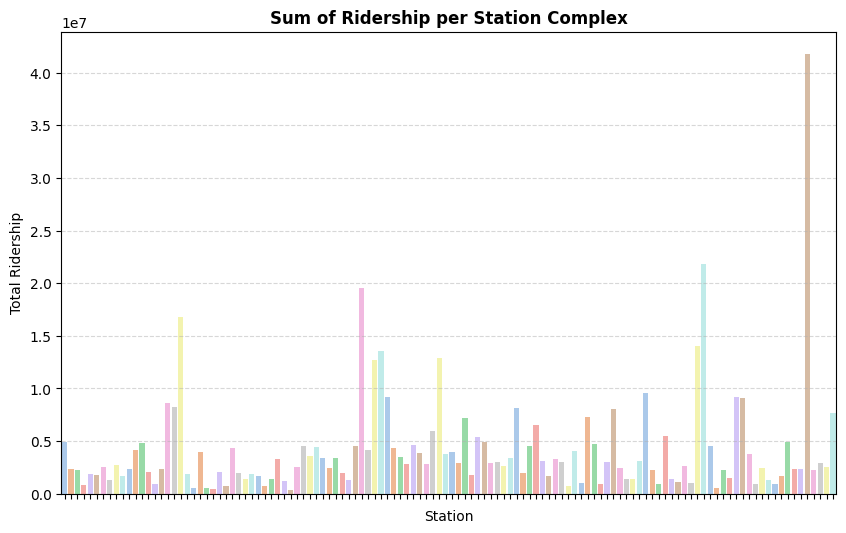

In [22]:
station_ridership = df.groupby('station_complex')['ridership'].sum()

# Plot the sum of ridership per station complex in a similar style
ax = sns.barplot(x=station_ridership.index, y=station_ridership.values, palette='pastel')
ax.set(xlabel='Station', ylabel='Total Ridership')
ax.set_title('Sum of Ridership per Station Complex', fontweight='bold')

ax.set_xticklabels([])  

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

There appears to be a large range of ridership across stations, now we will plot the top 10 out of interest.

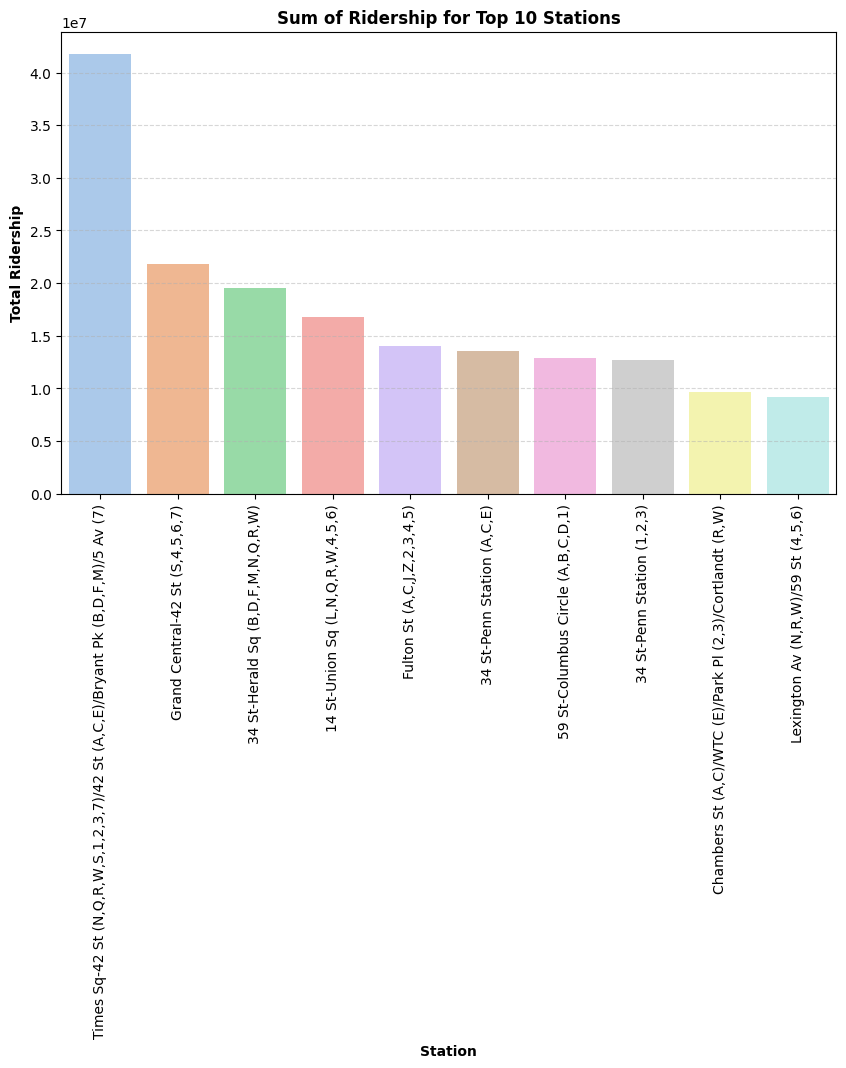

In [23]:
# Select the top 10 largest values
top_10_stations = station_ridership.nlargest(10)

# Plot the sum of ridership for the top 10 largest station complexes
sns.barplot(x=top_10_stations.index, y=top_10_stations.values, palette='pastel')
plt.xlabel('Station', fontweight='bold')
plt.ylabel('Total Ridership', fontweight='bold')
plt.title('Sum of Ridership for Top 10 Stations', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=90)

plt.show()

In [24]:
top_10_stations

station_complex
Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)/Bryant Pk (B,D,F,M)/5 Av (7)    41802643
Grand Central-42 St (S,4,5,6,7)                                                  21828736
34 St-Herald Sq (B,D,F,M,N,Q,R,W)                                                19526483
14 St-Union Sq (L,N,Q,R,W,4,5,6)                                                 16774154
Fulton St (A,C,J,Z,2,3,4,5)                                                      14005905
34 St-Penn Station (A,C,E)                                                       13532458
59 St-Columbus Circle (A,B,C,D,1)                                                12891651
34 St-Penn Station (1,2,3)                                                       12660562
Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortlandt (R,W)                           9609262
Lexington Av (N,R,W)/59 St (4,5,6)                                                9202456
Name: ridership, dtype: int64

**Observations:** Times square towers above the rest by a significant margin. Notably, most of the top 10 stations are located in downtown manhattan, which makes logical sense as to why they'd be so busy. 

So far, everything looks good witht the 2022 February-December data. We can save this to a csv file now for later use in modelling.

In [25]:
df.to_csv('2022_subway_feb_onwards_cleaned.csv', index=False)

## January 2022 data
---
Due to the afformentioned format change mentioned above, the January data is slightly more difficult to work with. However, we include it in order to match the timeframe covered by the taxi data. 

In [26]:
df = pd.read_csv('Subway_Data/Turnstile_Usage_Data__2022.csv')

In [27]:
df.shape

(10963251, 11)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963251 entries, 0 to 10963250
Data columns (total 11 columns):
 #   Column                                                      Dtype 
---  ------                                                      ----- 
 0   C/A                                                         object
 1   Unit                                                        object
 2   SCP                                                         object
 3   Station                                                     object
 4   Line Name                                                   object
 5   Division                                                    object
 6   Date                                                        object
 7   Time                                                        object
 8   Description                                                 object
 9   Entries                                                     int64 
 10  Exits           

In [29]:
df.head(20)

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2022,03:00:00,REGULAR,7811029,2770909
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2022,07:00:00,REGULAR,7811032,2770930
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2022,11:00:00,REGULAR,7811067,2771080
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2022,15:00:00,REGULAR,7811217,2771126
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2022,19:00:00,REGULAR,7811477,2771174
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/30/2022,23:00:00,REGULAR,7811576,2771206
6,A002,R051,02-00-01,59 ST,NQR456W,BMT,12/30/2022,03:00:00,REGULAR,6907603,1632919
7,A002,R051,02-00-01,59 ST,NQR456W,BMT,12/30/2022,07:00:00,REGULAR,6907607,1632933
8,A002,R051,02-00-01,59 ST,NQR456W,BMT,12/30/2022,11:00:00,REGULAR,6907630,1633000
9,A002,R051,02-00-01,59 ST,NQR456W,BMT,12/30/2022,15:00:00,REGULAR,6907758,1633046


We can see the features are different than the updated format. At first glance, this doesn't seem too disorderly. However, there's a couple of key issues with the older format.
- Entries and exits are a running total rather than per hour. This isn't a large issue as we can subtract the previous number from current to get the number for that timeframe.
- Rather than aggregating entries and exits per station like the new format, the old format actually kept count per individual turnstile. 
- Readings are every 4 hours instead of 1, and moreover not all readings are taken at the same time. That is, one turnstiles 4 hour window is not necessarily the same as other turnstiles windows.
- Remote units generally denote a specific station, but some stations have several associated remote units.

That's a very brief overlook on some of the issues with the old format. A great article by Chris Whong details all of the difficulties very well here: https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0

Chris Whong summed up the issues very well, and how he went about dealing with them. Based off his article, we loosly based a script to clean the data off following some of the techniques he mentioned. We need only run this once on the original data, and we can then load in the new csv file and work from there. 

The old format also contains information for all of 2022, so we will filter to only include January before processing the data.

In [30]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [31]:
df = df[(df['Date'].dt.month == 1) & (df['Date'].dt.year == 2022)]

In [32]:
df

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
10034359,A002,R051,02-00-00,59 ST,NQR456W,BMT,2022-01-31,03:00:00,REGULAR,7682666,2660008
10034360,A002,R051,02-00-00,59 ST,NQR456W,BMT,2022-01-31,07:00:00,REGULAR,7682667,2660049
10034361,A002,R051,02-00-00,59 ST,NQR456W,BMT,2022-01-31,11:00:00,REGULAR,7682688,2660273
10034362,A002,R051,02-00-00,59 ST,NQR456W,BMT,2022-01-31,15:00:00,REGULAR,7682737,2660345
10034363,A002,R051,02-00-00,59 ST,NQR456W,BMT,2022-01-31,19:00:00,REGULAR,7682900,2660428
...,...,...,...,...,...,...,...,...,...,...,...
10963246,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-01-01,00:00:00,REGULAR,5562,1001
10963247,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-01-01,04:00:00,REGULAR,5562,1001
10963248,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-01-01,08:00:00,REGULAR,5562,1001
10963249,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-01-01,16:00:00,REGULAR,5562,1006


In [33]:
df.shape

(928892, 11)

In [34]:
#df_turnstile = pd.read_csv('Subway_Data/Turnstile_Usage_Data__2022.csv')
df_turnstile = df.copy()
df_turnstile.columns = df_turnstile.columns.str.strip()

geocoded_df = pd.read_csv('Subway_Data/geocoded.csv', header=None)

# Assign column names
column_names = ['Unit', 'C/A', 'Station', 'Line Name', 'Division', 'Latitude', 'Longitude']
geocoded_df.columns = column_names

columns_to_drop = ['Division', 'Line Name']
df_turnstile.drop(columns=columns_to_drop, inplace=True)
geocoded_df.drop(columns=columns_to_drop, inplace=True)

merged_df = df_turnstile.merge(geocoded_df, on=['C/A', 'Unit', 'Station'], how='left')

# Define the coordinates that represent the boundary of Manhattan
manhattan_boundary = Polygon([
    (-74.0096665, 40.7628611),
    (-74.0096665, 40.7600006),
    (-74.0234083, 40.7103125),
    (-74.0265002, 40.6775136),
    (-73.9742814, 40.7056279),
    (-73.9577912, 40.7477772),
    (-73.9395833, 40.7714419),
    (-73.9261851, 40.7966576),
    (-73.9323689, 40.8247216),
    (-73.9241238, 40.8480992),
    (-73.9072901, 40.8714685),
    (-73.9316818, 40.8810735),
    (-74.0096665, 40.7628611)
])

# Convert DataFrame to GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(merged_df['Longitude'], merged_df['Latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Filter the GeoDataFrame to include stations within the Manhattan boundary
manhattan_stations = gdf[gdf.geometry.within(manhattan_boundary)]

manhattan_stations.columns = manhattan_stations.columns.str.strip()

# Sort the DataFrame by 'SCP', 'Unit', 'C/A', 'Station', 'Date', and 'Time'
manhattan_stations_sorted = manhattan_stations.sort_values(by=['SCP', 'Unit', 'C/A', 'Station', 'Date', 'Time'])

# Convert the 'Date' column to datetime type
manhattan_stations_sorted['Date'] = pd.to_datetime(manhattan_stations_sorted['Date'])

# Convert the 'Time' column to time type and extract the time component
manhattan_stations_sorted['Time'] = pd.to_datetime(manhattan_stations_sorted['Time'], format='%H:%M:%S').dt.time

# Calculate the difference in entries and exits for each turnstile within the same day
manhattan_stations_sorted['Entries_diff'] = manhattan_stations_sorted.groupby(['SCP', 'Unit', 'C/A', 'Station', 'Date'])['Entries'].diff()
manhattan_stations_sorted['Exits_diff'] = manhattan_stations_sorted.groupby(['SCP', 'Unit', 'C/A', 'Station', 'Date'])['Exits'].diff()

# Drop the first row for each turnstile within the same day
#manhattan_stations_sorted = manhattan_stations_sorted.dropna(subset=['Entries_diff', 'Exits_diff'])

# Reset the index
manhattan_stations_sorted = manhattan_stations_sorted.reset_index(drop=True)

manhattan_stations_sorted.to_csv('Subway_Data/processed_data.csv', index=False)
print(f"The input file has been processed and saved as {'Subway_Data/processed_data.csv'}")

The input file has been processed and saved as Subway_Data/processed_data.csv


Now, we can load in the more organised dataset, and work from there.

In [35]:
df = pd.read_csv('Subway_Data/processed_data.csv')

In [36]:
df.head()

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,Latitude,Longitude,geometry,Entries_diff,Exits_diff
0,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,03:00:00,REGULAR,328000,947869,40.752247,-73.993456,POINT (-73.993456 40.752247),NaN,NaN
1,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,07:00:00,REGULAR,328005,947875,40.752247,-73.993456,POINT (-73.993456 40.752247),5.0,6.0
2,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,11:00:00,REGULAR,328017,947920,40.752247,-73.993456,POINT (-73.993456 40.752247),12.0,45.0
3,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,15:00:00,REGULAR,328042,947991,40.752247,-73.993456,POINT (-73.993456 40.752247),25.0,71.0
4,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,19:00:00,REGULAR,328086,948064,40.752247,-73.993456,POINT (-73.993456 40.752247),44.0,73.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246620 entries, 0 to 246619
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   C/A           246620 non-null  object 
 1   Unit          246620 non-null  object 
 2   SCP           246620 non-null  object 
 3   Station       246620 non-null  object 
 4   Date          246620 non-null  object 
 5   Time          246620 non-null  object 
 6   Description   246620 non-null  object 
 7   Entries       246620 non-null  int64  
 8   Exits         246620 non-null  int64  
 9   Latitude      246620 non-null  float64
 10  Longitude     246620 non-null  float64
 11  geometry      246620 non-null  object 
 12  Entries_diff  205468 non-null  float64
 13  Exits_diff    205468 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 26.3+ MB


Things seen to have processed correctly from the script. We will now perform the same tests for negative values, outliers and missing values on the January data.

**Checking for missing values**

In [38]:
df.isnull().sum()

C/A                 0
Unit                0
SCP                 0
Station             0
Date                0
Time                0
Description         0
Entries             0
Exits               0
Latitude            0
Longitude           0
geometry            0
Entries_diff    41152
Exits_diff      41152
dtype: int64

There's quite a large proportion of missing values. Some of these will be for the first recorded count at each turnstile, as there's no previous value to minus. However, over 40,000 seems too high for this to be the only cause. This will need to be investigated.

**Checking for negative values**

In [39]:
negative_counts = {}

for column in df.columns:
    # Checking for numeric columns
    if pd.api.types.is_numeric_dtype(df[column]):
        negative_count = df[column].lt(0).sum()
        negative_counts[column] = negative_count

for column, count in negative_counts.items():
    print(f"Column '{column}' has {count} negative value(s).")

Column 'Entries' has 0 negative value(s).
Column 'Exits' has 0 negative value(s).
Column 'Latitude' has 0 negative value(s).
Column 'Longitude' has 246620 negative value(s).
Column 'Entries_diff' has 1753 negative value(s).
Column 'Exits_diff' has 995 negative value(s).


There are some negative values for Entries_diff and Exits_diff which doesn't make sense. In the article linked above it mentions some turnstiles are actually counting down instead of up. Perhaps this is the reason why. Since they make only small proportion of our data, we will remove them. However, they will be revisited, perhaps using absolute difference would solve this issue.

**Checking for Outliers**

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Entries,246620.0,4.226585e+07,2.195322e+08,0.000000e+00,327680.000000,1.613643e+06,7.022389e+06,2.128581e+09
Exits,246620.0,3.998429e+07,2.202768e+08,0.000000e+00,177482.250000,1.096403e+06,4.988272e+06,2.049503e+09
Latitude,246620.0,4.075396e+01,4.021499e-02,4.069736e+01,40.718697,4.074953e+01,4.077857e+01,4.086936e+01
Longitude,246620.0,-7.398412e+01,2.368519e-02,-7.401410e+01,-74.003917,-7.399047e+01,-7.397187e+01,-7.391533e+01
Entries_diff,205468.0,1.953451e+04,6.267908e+06,-7.354609e+06,5.000000,2.800000e+01,8.600000e+01,2.022148e+09
Exits_diff,205468.0,8.727626e+03,3.944934e+06,-5.977644e+06,9.000000,4.000000e+01,1.130000e+02,1.788166e+09


Entries_diff seems to have some extreme outliers, with a minimum value of of approximately -7.3 million, and a maximum value of over 2 billion. Given these are counts for one single turnstile in 4 hours, these are definitely errors. 
<br><br>
Our suspicion is that some turnstiles entry/exit count hit its maximum and reset to 0, leading to the astronomically large difference seen when getting the difference between the current and previous value. This is outlined in both the data dictionary and Chris Whangs article linked above. The counter can only go so high before resetting.
<br><br>
Let's investigate the top 10 largest positive/negative values.

In [41]:
df.nlargest(10, 'Entries_diff')

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,Latitude,Longitude,geometry,Entries_diff,Exits_diff
82285,R258,R132,00-03-01,125 ST,2022-01-21,16:00:00,REGULAR,2030106827,1795201203,40.804406,-73.937452,POINT (-73.937452 40.804406),2.022148e+09,1.788166e+09
239079,R232A,R176,03-06-00,33 ST,2022-01-15,16:00:00,REGULAR,1996226557,25,40.746119,-73.981826,POINT (-73.981826 40.746119),1.995748e+09,-5.798600e+04
168963,PTH17,R541,01-00-08,THIRTY THIRD ST,2022-01-07,23:33:25,REGULAR,497243,434223,40.748931,-73.988113,POINT (-73.988113 40.748931),4.436530e+05,3.971060e+05
17871,PTH11,R545,00-00-00,14TH STREET,2022-01-30,14:59:47,REGULAR,389413,39178,40.737434,-73.996785,POINT (-73.996785 40.737434),3.793550e+05,-3.051300e+05
13588,R138,R293,00-00-00,34 ST-PENN STA,2022-01-27,09:00:00,REGULAR,1466611,465015,40.750264,-73.992984,POINT (-73.992984 40.750264),1.033000e+03,8.800000e+01
215587,A033,R170,02-00-05,14 ST-UNION SQ,2022-01-20,20:00:00,REGULAR,552507,385270,40.734836,-73.990688,POINT (-73.990688 40.734836),9.790000e+02,1.910000e+02
13576,R138,R293,00-00-00,34 ST-PENN STA,2022-01-25,09:00:00,REGULAR,1461872,463409,40.750264,-73.992984,POINT (-73.992984 40.750264),9.520000e+02,1.000000e+02
139154,R245A,R051,01-00-01,59 ST,2022-01-04,19:00:00,REGULAR,26429,15733,40.762796,-73.967686,POINT (-73.967686 40.762796),9.310000e+02,1.610000e+02
82796,R251,R144,00-03-01,96 ST,2022-01-13,20:00:00,REGULAR,4454927,772045,40.785822,-73.950970,POINT (-73.95097 40.785822),9.280000e+02,3.800000e+01
13582,R138,R293,00-00-00,34 ST-PENN STA,2022-01-26,09:00:00,REGULAR,1464129,464205,40.750264,-73.992984,POINT (-73.992984 40.750264),9.200000e+02,1.110000e+02


The top 4 values seem implausible, while the 5th largest seems possible. Just over a 1,000 entries in 4 hours could be possible, especially as we saw above that 34 ST Penn St was one of the busiest stations.

In [42]:
df.nsmallest(10, 'Entries_diff')

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,Latitude,Longitude,geometry,Entries_diff,Exits_diff
214483,A033,R170,02-00-04,14 ST-UNION SQ,2022-01-21,16:00:00,REGULAR,302,201,40.734836,-73.990688,POINT (-73.990688 40.734836),-7354609.0,-5977644.0
180772,R242,R049,01-03-03,51 ST,2022-01-07,19:00:00,REGULAR,47,64,40.757108,-73.971870,POINT (-73.97187 40.757108),-6132645.0,-4495588.0
6954,R162,R166,00-00-00,79 ST,2022-01-10,16:00:00,REGULAR,186,168,40.783872,-73.979938,POINT (-73.979938 40.783872),-2506162.0,-1627593.0
48326,R119,R320,00-00-02,CANAL ST,2022-01-12,20:00:00,REGULAR,172,27,40.722819,-74.006267,POINT (-74.006267 40.722819),-533929.0,-210658.0
168964,PTH17,R541,01-00-08,THIRTY THIRD ST,2022-01-07,23:34:05,REGULAR,53687,37165,40.748931,-73.988113,POINT (-73.988113 40.748931),-443556.0,-397058.0
17870,PTH11,R545,00-00-00,14TH STREET,2022-01-30,14:54:09,REGULAR,10058,344308,40.737434,-73.996785,POINT (-73.996785 40.737434),-379325.0,305137.0
129643,R155,R116,01-00-00,50 ST,2022-01-21,15:00:00,REGULAR,18,18,40.761675,-73.983908,POINT (-73.983908 40.761675),-224620.0,-171719.0
136284,N029,R333,01-00-00,116 ST,2022-01-14,20:00:00,REGULAR,7,11,40.805072,-73.954833,POINT (-73.954833 40.805072),-112393.0,-123224.0
147377,PTH21,R540,01-00-01,PATH WTC 2,2022-01-12,13:41:51,REGULAR,4,3,40.711638,-74.010708,POINT (-74.010708 40.711638),-97707.0,-79152.0
189323,R113,R028,01-06-00,FULTON ST,2022-01-07,14:00:00,REGULAR,3,1,40.709938,-74.007983,POINT (-74.007983 40.709938),-10889.0,-42711.0


**Action to Take:** For positive outliers, we will remove the top 4 rows as the rest seem reasonable. For negative values, we are going to drop all these rows as mentoioned above. they will have a large impact on our predicted outcome. They are only a small proportion of our overall dataset as well. In future, we may revisit the script for cleaning to try and account for these negative values/turnstiles counting down. Perhaps using abolsute differences would be a better solution. For the initial model however, this is the approach we are taking.

In [43]:
# Dropping top 4 largest rows
df = df.drop(df.nlargest(4, 'Entries_diff').index)

# Dropping negative rows
df = df[df['Entries_diff'] >= 0]
df = df[df['Exits_diff'] >= 0]

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Entries,203467.0,3.060932e+07,1.757014e+08,0.000000,327680.000000,1.550572e+06,6.786368e+06,2.116174e+09
Exits,203467.0,2.843016e+07,1.768725e+08,0.000000,175802.000000,1.079208e+06,4.743651e+06,2.031632e+09
Latitude,203467.0,4.075372e+01,4.009853e-02,40.697356,40.718697,4.074953e+01,4.077555e+01,4.086936e+01
Longitude,203467.0,-7.398424e+01,2.363074e-02,-74.014099,-74.003917,-7.399047e+01,-7.397187e+01,-7.391533e+01
Entries_diff,203467.0,6.387464e+01,8.992381e+01,0.000000,5.000000,2.800000e+01,8.700000e+01,1.033000e+03
Exits_diff,203467.0,8.730690e+01,1.268471e+02,0.000000,9.000000,4.000000e+01,1.130000e+02,1.914000e+03


Things seem more appropriate now. There's still the issue of missing values which will need to be accounted for when training the initials model.

## Visualising the Data
---
As we did before, we are going to extract date time features for hour and day of the week in order to visualise the ridership grouped by these features. We do not need month anymore as it only contains records for January.

In [45]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

df['Hour'] = df['Time'].dt.hour
df['Day'] = df['Date'].dt.day_name()

In [46]:
df.head()

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,Latitude,Longitude,geometry,Entries_diff,Exits_diff,Hour,Day
1,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,2023-07-02 07:00:00,REGULAR,328005,947875,40.752247,-73.993456,POINT (-73.993456 40.752247),5.0,6.0,7,Saturday
2,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,2023-07-02 11:00:00,REGULAR,328017,947920,40.752247,-73.993456,POINT (-73.993456 40.752247),12.0,45.0,11,Saturday
3,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,2023-07-02 15:00:00,REGULAR,328042,947991,40.752247,-73.993456,POINT (-73.993456 40.752247),25.0,71.0,15,Saturday
4,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,2023-07-02 19:00:00,REGULAR,328086,948064,40.752247,-73.993456,POINT (-73.993456 40.752247),44.0,73.0,19,Saturday
5,N067,R012,00-00-00,34 ST-PENN STA,2022-01-01,2023-07-02 23:00:00,REGULAR,328107,948115,40.752247,-73.993456,POINT (-73.993456 40.752247),21.0,51.0,23,Saturday


### Number of Riders per Weekday

The data dictionary for the new format describes ridership as the 'Total number of riders that entered a subway complex via OMNY or MetroCard at the specific hour.'. As such, we will be using the Entries_diff column as ridership, as it seems to make most sense in the sense of continuity. 

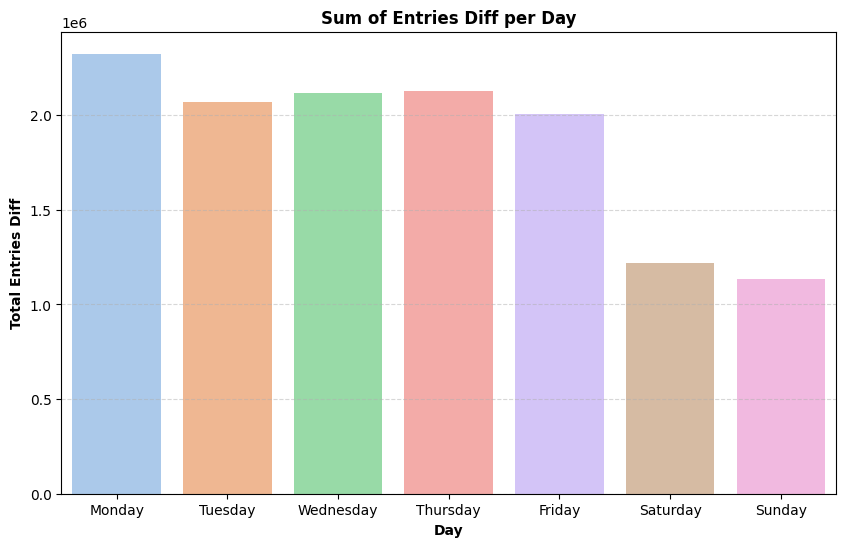

In [47]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_entries_diff = df.groupby('Day')['Entries_diff'].sum()

sns.barplot(x=daily_entries_diff.index, y=daily_entries_diff.values, order=day_order, palette='pastel')

plt.xlabel('Day', fontweight='bold')
plt.ylabel('Total Entries Diff', fontweight='bold')
plt.title('Sum of Entries Diff per Day', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [48]:
daily_entries_diff

Day
Friday       2004897.0
Monday       2324306.0
Saturday     1220771.0
Sunday       1134210.0
Thursday     2129698.0
Tuesday      2067089.0
Wednesday    2115410.0
Name: Entries_diff, dtype: float64

**Observations:** This is similar to the trends we saw in the data above. Weekdays appear to be busiest compared to the weekend. This looks good for our prediction, day of the week has a noticable impact on ridership.

### Number of Riders per Hour

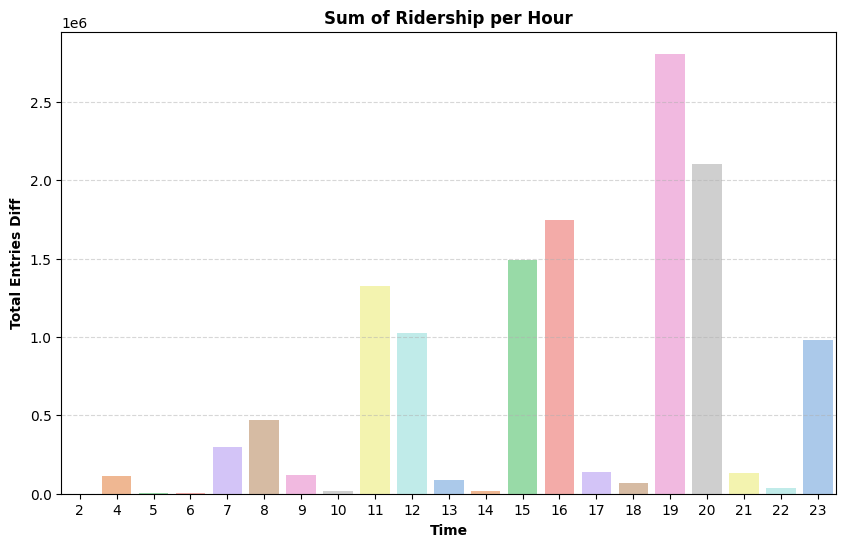

In [49]:
hourly_entries_diff = df.groupby('Hour')['Entries_diff'].sum()

sns.barplot(x=hourly_entries_diff.index, y=hourly_entries_diff.values, palette='pastel')

plt.xlabel('Time', fontweight='bold')
plt.ylabel('Total Entries Diff', fontweight='bold')
plt.title('Sum of Ridership per Hour', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [50]:
hourly_entries_diff

Hour
2           5.0
4      112652.0
5        6169.0
6        2677.0
7      299584.0
8      469439.0
9      120197.0
10      16768.0
11    1323162.0
12    1026459.0
13      90423.0
14      19819.0
15    1493511.0
16    1748268.0
17     136352.0
18      71456.0
19    2806372.0
20    2106105.0
21     130609.0
22      33648.0
23     982706.0
Name: Entries_diff, dtype: float64

**Observations:** At first, this looks like an error, until we remember that observation windows are covering 4 hours instead of hourly. Moreover, not every station has the same 4 hour-windows. We will need some way for the low number of observations at certain times of the day. We will create 4 hour bins to group all observations within these periods. This should hopefully capture trends across the early morning, early afternoon, late afternoon and evening periods.

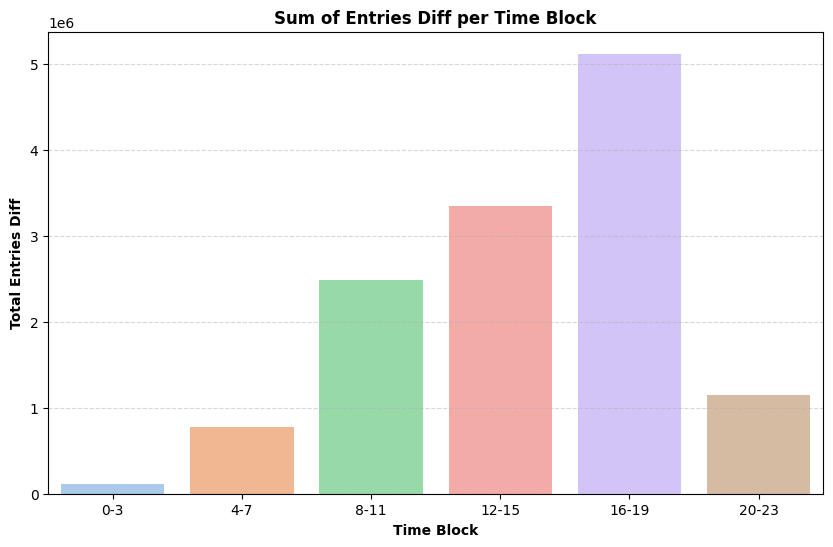

In [51]:
# Create a new column 'Time Block' based on the 'Hour' column
df['Time Block'] = pd.cut(df['Hour'], bins=range(0, 25, 4), labels=['0-3', '4-7', '8-11', '12-15', '16-19', '20-23'])

# Group by 'Time Block' and calculate the sum of 'Entries_diff' per block
blocked_hourly_entries_diff = df.groupby('Time Block')['Entries_diff'].sum()

sns.barplot(x=blocked_hourly_entries_diff.index, y=blocked_hourly_entries_diff.values, palette='pastel')

plt.xlabel('Time Block', fontweight='bold')
plt.ylabel('Total Entries Diff', fontweight='bold')
plt.title('Sum of Entries Diff per Time Block', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [52]:
blocked_hourly_entries_diff

Time Block
0-3       112657.0
4-7       777869.0
8-11     2486586.0
12-15    3352021.0
16-19    5120285.0
20-23    1146963.0
Name: Entries_diff, dtype: float64

**Observations:** This looks much better. Although larger intervals, we can see very early morning is the quietest, with an uptick as the day goes on. It peaks in the early evening, which is consistent with the data above. These time blocks should be a good predictor for ridership.

We will now save the January 2022 data to a csv file for use in modelling.

In [53]:
df.to_csv('2022_subway_jan_cleaned.csv', index=False)